In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [ ]:
import torch
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer
from src.utils import ROCOv2CaptionsDataset
from src.training import CLIPNLoss
from torch.utils.data import DataLoader
from src.clipn import CLIPNAdapter, AltCLIPNAdapter

In [3]:
# Load the model and config files from the Hugging Face Hub
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

clipn_model = AltCLIPNAdapter(
    model, 
    tokenizer, 
    num_no_texts=16,
    transformer_path="text.transformer.encoder",
    # frozen=False
)

# model, preprocess = create_model_from_pretrained('hf-hub:laion/CLIP-ViT-B-16-laion2B-s34B-b88K')
# tokenizer = get_tokenizer('hf-hub:laion/CLIP-ViT-B-16-laion2B-s34B-b88K')

# clipn_model = AltCLIPNAdapter(
#     model, 
#     tokenizer, 
#     num_no_texts=16,
#     transformer_path="transformer",
#     frozen=False
# )


# clipn_model = model

In [4]:
train_csv = '/repo/MEDCLIPN/data/ROCOv2_dataset/metadata/train_captions.csv'
train_img_dir = '/repo/MEDCLIPN/data/ROCOv2_dataset/images/train'

train_dataset = ROCOv2CaptionsDataset(train_csv, train_img_dir, transform=preprocess, tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)

  0%|          | 3/1874 [00:01<18:53,  1.65it/s, Avg. Cosine Similarity: 0.4592]
/tmp/ipykernel_554489/1025007389.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


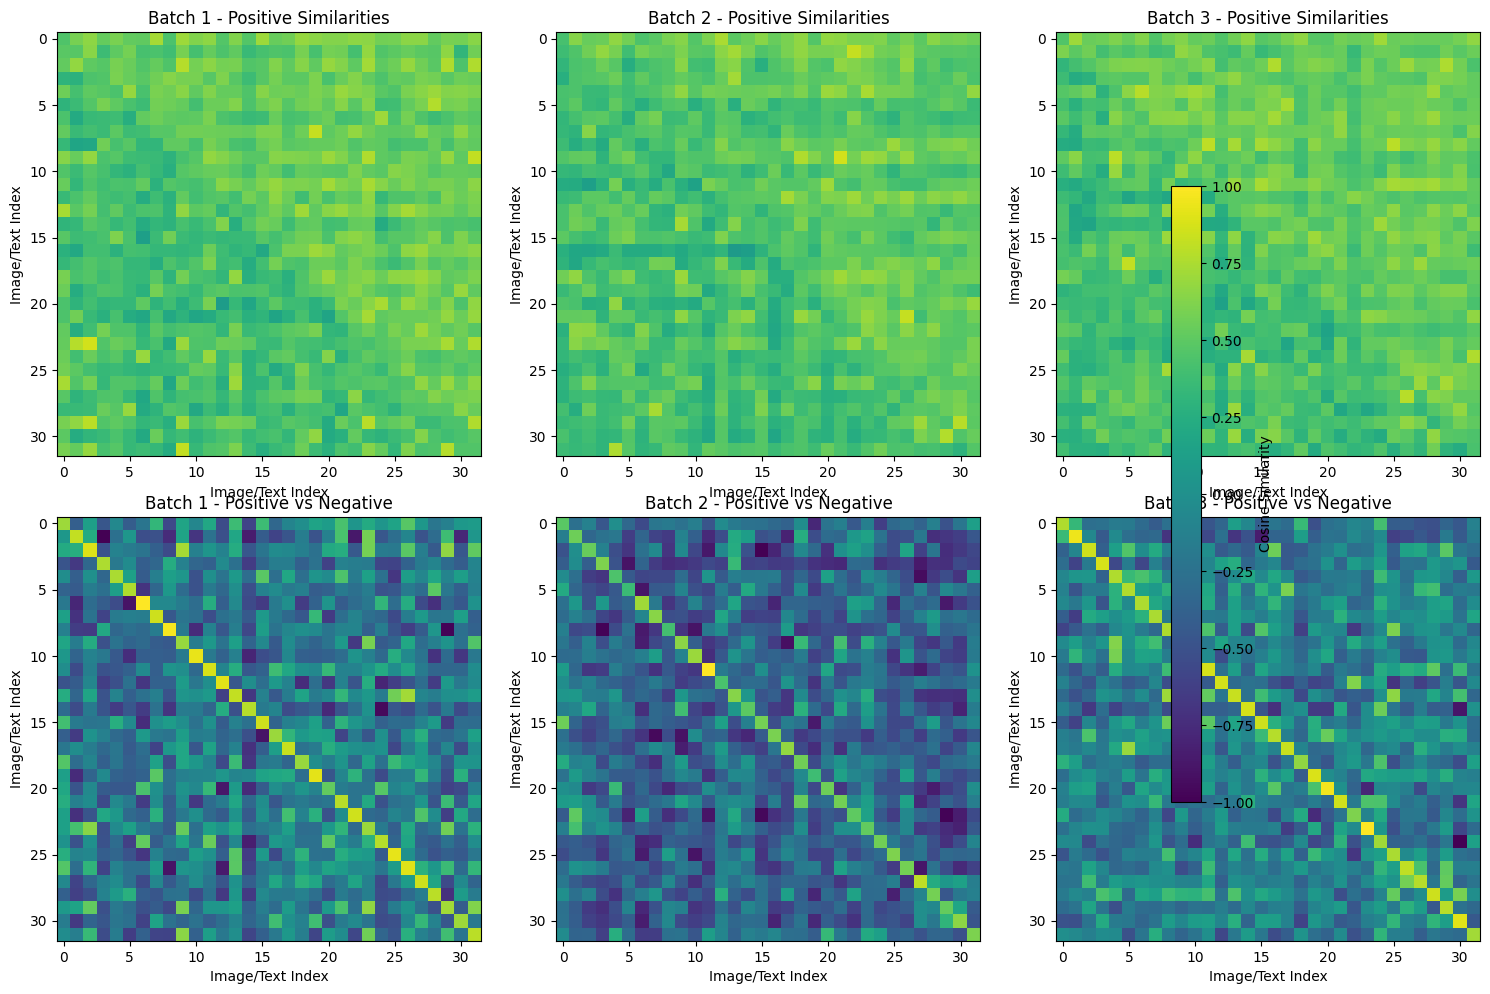


Final Average Cosine Similarity over 3 batches: 0.4592
Fraction of dataset processed: 0.0016


In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clipn_model = clipn_model.to(device)
clipn_model.train()

cumul_sim = 0
total_preds = 0

batches_num = 3
fig, axes = plt.subplots(2, batches_num, figsize=(15, 10))
if batches_num == 1:
    axes = axes.reshape(-1, 1)

batch_idx = 0
testing_progress = tqdm(train_loader)

for images, captions in testing_progress:
    if batch_idx >= batches_num:
        break

    batch_size = len(images)

    total_preds += batch_size

    images = images.to(device)
    captions = captions.reshape((batch_size, -1)).to(device)

    # Generate embeddings
    with torch.no_grad():
        img_embs, text_embs, text_no_embs, _ = clipn_model(images.to(device), captions.to(device))

    # Normalize embeddings
    img_embs_norm = F.normalize(img_embs, p=2, dim=-1)
    text_embs_norm = F.normalize(text_embs, p=2, dim=-1)
    text_no_embs_norm = F.normalize(text_no_embs, p=2, dim=-1)

    # Cosine similarity for diagonal
    diag_similarities = F.cosine_similarity(img_embs_norm, text_embs_norm, dim=-1)

    cumul_sim += diag_similarities.sum().item()

    testing_progress.set_postfix_str(f"Avg. Cosine Similarity: {cumul_sim / total_preds:.4f}")

    # === POSITIVE SIMILARITIES MATRIX ===
    # Full similarity matrices using matrix multiplication
    img_img_sim = img_embs_norm @ img_embs_norm.T
    text_text_sim = text_embs_norm @ text_embs_norm.T

    lower_triangle = torch.tril(img_img_sim, diagonal=-1)
    upper_triangle = torch.triu(text_text_sim, diagonal=1)
    diag_matrix = torch.diag(diag_similarities)
    
    combined_matrix_positive = lower_triangle + upper_triangle + diag_matrix

    # === NEGATIVE SIMILARITIES MATRIX ===
    # Image-text negative similarities for diagonal and upper triangle
    img_text_no_sim = img_embs_norm @ text_no_embs_norm.T
    
    # Extract diagonal and upper triangle from img-text_no similarities
    upper_triangle_no = torch.triu(img_text_no_sim)
    lower_triangle_imgtext = torch.tril(img_embs_norm @ text_embs_norm.T, diagonal=-1)
    
    combined_matrix_negative = lower_triangle_imgtext + upper_triangle_no

    # Convert to NumPy for plotting
    combined_matrix_positive_np = combined_matrix_positive.cpu().detach().numpy()
    combined_matrix_negative_np = combined_matrix_negative.cpu().detach().numpy()

    # Plot positive similarities (top row)
    im1 = axes[0, batch_idx].imshow(combined_matrix_positive_np, cmap='viridis', vmin=-1, vmax=1)
    axes[0, batch_idx].set_title(f'Batch {batch_idx + 1} - Positive Similarities')
    axes[0, batch_idx].set_xlabel('Image/Text Index')
    axes[0, batch_idx].set_ylabel('Image/Text Index')

    # Plot negative similarities (bottom row)
    im2 = axes[1, batch_idx].imshow(combined_matrix_negative_np, cmap='viridis', vmin=-1, vmax=1)
    axes[1, batch_idx].set_title(f'Batch {batch_idx + 1} - Positive vs Negative')
    axes[1, batch_idx].set_xlabel('Image/Text Index')
    axes[1, batch_idx].set_ylabel('Image/Text Index')

    batch_idx += 1

# Add colorbar and finalize plot
fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.8, label='Cosine Similarity')
plt.tight_layout()
plt.show()

# Final stats
final_avg_similarity = cumul_sim / total_preds
print(f"\nFinal Average Cosine Similarity over {batches_num} batches: {final_avg_similarity:.4f}")
print(f"Fraction of dataset processed: {total_preds / len(train_loader.dataset):.4f}")


In [ ]:
def train_clipn_step(model, dataloader, optimizer, loss_fn, device='cuda'):
    """
    Single training step for CLIPN
    
    Args:
        model: CLIPN model
        dataloader: DataLoader with image-text pairs
        optimizer: Optimizer (e.g., AdamW)
        loss_fn: CLIPNLoss instance
        device: Device to run on
        
    Returns:
        loss_dict: Dictionary with loss values
    """
    model.train()
    
    for batch_idx, (images, texts) in enumerate(dataloader):
        images = images.to(device)
        texts = texts.to(device)
        
        # Forward pass - get features from your model
        image_features, text_features, text_features_no, logit_scale_exp = model(images, texts)
        
        # Compute CLIPN loss
        total_loss, loss_dict = loss_fn(image_features, text_features, text_features_no)
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}: {loss_dict}")
        
        return loss_dict

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clipn_model = clipn_model.to(device)

# Initialize loss function and optimizer
clipn_loss = CLIPNLoss(temperature=0.07, mode="cosine")
optimizer = torch.optim.AdamW(
    clipn_model.parameters(), 
    lr=1e-4, 
    weight_decay=0.01
)

# Training loop
print("Starting CLIPN training...")
for epoch in range(5):  # Adjust number of epochs as needed
    epoch_losses = []
    
    for batch_idx, (images, texts) in enumerate(train_loader):
        batch_size = len(images)
        images = images.to(device)
        texts = texts.reshape((batch_size, -1)).to(device)
        
        # Forward pass
        image_features, text_features, text_features_no, logit_scale_exp = clipn_model(images, texts)
        
        # Compute loss
        total_loss, loss_dict = clipn_loss(image_features, text_features, text_features_no)
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss_dict)
        
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}: {loss_dict}")
        
    
    # Print epoch summary
    avg_total_loss = np.mean([l['total_loss'] for l in epoch_losses])
    avg_itbo_loss = np.mean([l['itbo_loss'] for l in epoch_losses])
    avg_tso_loss = np.mean([l['tso_loss'] for l in epoch_losses])
    
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Average Total Loss: {avg_total_loss:.4f}")
    print(f"  Average ITBO Loss: {avg_itbo_loss:.4f}")  
    print(f"  Average TSO Loss: {avg_tso_loss:.4f}")
    print("-" * 50)

print("Training completed!")

Starting CLIPN training...
Epoch 0, Batch 0: {'total_loss': 3.40498685836792, 'itbo_loss': 1.426151990890503, 'tso_loss': 1.978834867477417}
Epoch 0, Batch 10: {'total_loss': 1.5943310260772705, 'itbo_loss': 0.3487592041492462, 'tso_loss': 1.2455718517303467}


In [ ]:
torch.save(clipn_model, "/repo/ALTMEDCLIPN/model/biomed_clip_better")